# Proyecto de Investigación: Modelos Numéricos
---

In [1]:
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from math import sqrt, pi

from project import eigen

## Modelo Matemático en Ecuaciones Diferenciales

$ m(x) \frac{\partial^{2}u}{\partial t^{2}} + EJ \frac{\partial^{4}u(x, t)}{\partial x^{4}} = p(x)g(t) \quad\text{;}\quad \Omega = \{x \in \mathbb{R}: 0 \leq x \leq L \}$

Condiciones de borde:

$\forall t \quad\text{en}\quad x = 0
\begin{cases}
u(0, t) = 0 \\
\frac{\partial u}{\partial x}|_{(0,t)} = 0
\end{cases}
$

$\forall t \quad\text{en}\quad x = L
\begin{cases}
EJ \frac{\partial^{2}u(x, t)}{\partial x^{2}} = M_{L} g_{c}(t) \\
EJ \frac{\partial^{3}u(x, t)}{\partial x^{3}} = 0
\end{cases}
$

Condiciones iniciales nulas.

## Datos del sistema

In [2]:
L = 420
EJ = 9.45e11
m = 64.8
p = 100
ML = 50000

## Modelo Matemático Discreto de N Grados de Libertad

Discretización del dominio

In [3]:
widgetN = widgets.FloatText()
display(widgetN)
N = 20
h = L/N

FloatText(value=0.0)

Forma discreta de la ecuación diferencial, de la forma:

$\mathbb{M} \cdot \bar{\ddot{u(t)}} + \mathbb{K} \cdot \bar{u(t)} = g(t) \cdot \bar{f_{p}} + g_{c}(t) \cdot \bar{f_{M}}$

Donde:

In [4]:
M = np.zeros((N, N))

for i in range(0, N):
    M[i, i] = m
    
K = np.zeros((N, N))
K[0, 0:3] = [7, -4, 1]
K[1, 0:4] = [-4, 6, -4, 1]

# Completar para N puntos de discretización
if (N > 4):
    for i in range(2, N-2):
        K[i, i-2:i+3] = [1, -4, 6, -4, 1]

K[N-2, N-4:N] = [1, -4, 5, -2]
K[N-1, N-3:N] = [2, -4, 2]

K = (EJ/h**4) * K

fp = np.full((N,), p)

fM = np.zeros((N,))
fM[N-2] = -1
fM[N-1] = 2
fM = (ML/(h*h)) * fM[:]

## Modelo Matemático de 1 Grado de Libertad

Se realiza un cambio de base del espacio generado por los modos naturales de vibración del modelo matemátiico discreto de N grados de libertad.

Es un problema de autovalores y autovectores, de la forma:

$(\mathbb{K} - \omega^{2}\mathbb{M}) \cdot \bar{\phi} = \bar{0}$

Se opera para llegar a la forma:

$(\mathbb{A} - \lambda \cdot \mathbb{I}) \cdot \bar{\phi} = \bar{0}$

Y se procede mediante el método de iteración inversa para calcular el primer autovalor y autovector:

In [5]:
A = LA.inv(M).dot(K)

alpha, phi = eigen.inverse_iteration(A)
# Se transforma el array 1D en 2D para poder transponerle y tratarlo
# como un vector columna. Debe existir una forma mejor CORREGIR
phi = np.array(phi)[np.newaxis].transpose()

Obtención del primer autovector por izquierda de la matriz $(\mathbb{K} - \omega^{2}\mathbb{M})$ se puede obtener como el primer autovector por derecha de la matriz $(\mathbb{K}^{T} - \omega^{2} \cdot \mathbb{M}^{T})$:

In [6]:
A = LA.inv(M.transpose()).dot(K.transpose())
alpha_n, phi_n = eigen.inverse_iteration(A) # Obtención del menor autovalor mediante método de potencia inversa
# Se transforma el array 1D en 2D para poder transponerle y tratarlo
# como un vector columna. Debe existir una forma mejor CORREGIR
phi_n = np.array(phi_n)[np.newaxis].transpose()

Falta explicar la descomposición modal (?)

Así es posible obtener la siguiente ecuación dinámica de un grado de libertad:

$\ddot{q(t)} + \omega_{n}^{2} \cdot q(t) = g(t) \cdot b_{p} + g_{c}(t) \cdot b_{M}$

In [7]:
mn = phi_n.transpose().dot(M.dot(phi))[0, 0]
kn = phi_n.transpose().dot(K.dot(phi))[0, 0]
print("mn = " + str(mn) + " - kn = " + str(kn))

mn = 348.94223203336526 - kn = 2013.170408216206


In [8]:
wn = sqrt(kn/mn)
print(sqrt(alpha), wn)

T = 2*pi/wn
print("T = " + str(T))

2.401936260308794 2.401947450047864
T = 2.615871261902245


In [9]:
bp = phi_n.transpose().dot(fp)/mn
bp = bp[0]
bM = phi_n.transpose().dot(fM)/mn
bM = bM[0]
print("bp = " + str(bp) + " - bM = " + str(bM))

bp = 2.4128045976265393 - bM = 0.023994587017530745


Es importante destacar que el método iterativo de potencias inverso solo se puede implementar en este caso de 1 grado de libertad, ya que solo es posible obtener el eigenpar menor (que es el fundamental y el que se necesita). Para el caso general es necesario la aplicación de otro método numérico.

## Resolución de la ecuación diferencial por reducción de orden
Siendo la ecuación diferencial de la forma:

$\ddot{q(t)} + \omega_{n}^{2} \cdot q(t) = g(t) \cdot b_{p} + g_{c}(t) \cdot b_{M}$

Se puede resolver mediante reducción de orden definiendo $y_{1}(t) = q(t)$ y $y_{2}(t) = \frac{dy_{1}}{dt}$, entonces:

$
\begin{cases}
\frac{dy_{1}}{dt} = y_{2}(t) \\
\frac{dy_{2}}{dt} = - \omega_{n}^{2} \cdot y_{1}(t) + g(t) \cdot b_{p} + g_{c}(t) \cdot b_{M}
\end{cases}
$


---
# Sistemas de Ecuaciones Diferenciales Ordinarias de Primer Orden

## Método de Euler

Es uno de los métodos más antiguos y mejor conocidos de **integración numérica** de ecuaciones diferenciales. Fue ideado por Euler hace más de 200 años. Es un método fácil de entender y de usar, pero no es tan preciso como otros métodos. En general, se trata de un **Método de Runge-Kutta de Primer Orden**.

Siendo la ecuación diferencial de primer orden de la forma:

$\frac{dy}{dt} = f(x, y)$

La expresión para su cálculo es:

$y_{i+1} = y_{i} + h \cdot f(x_{i}, y_{i})$

In [10]:
A = np.array([[0, 1], [-wn**2, 0]])

# Condiciones iniciales del sistema
y0 = np.zeros((2,))
t0 = 0

# Incremento de tiempo
Dt = 1e-2
# Cantidad de puntos
tf = 6*T
NDt = np.ceil(tf/Dt).astype(int) # Se redondea al entero superior y se castea a un entero

# Dimensionamiento
t = np.zeros((NDt,))
y = np.zeros((2, NDt))

ya = np.zeros((2,))
k1 = np.zeros((2,))

# Cargas externas
# g(t) impulso unitario en t=0
g = np.zeros((NDt,))
g[0] = 1

B = np.zeros((2, NDt))
B[1, :] = g

# Inicialización del sistema
t[0] = t0
y[:, 0] = y0

for i in range(0, NDt-1):
    ya = y[:, i]
    ta = t[i]
    
    k1 = Dt * A.dot(ya) + B[:, i]
    
    y[:, i+1] = ya + k1
    t[i+1] = ta + Dt # Esto se puede simplificar con np.arange al principio

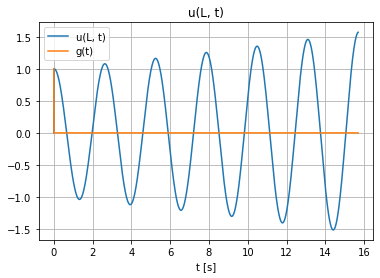

In [11]:
plt.plot(t, y[1, :], label='u(L, t)')
plt.plot(t, g, label='g(t)')
plt.title('u(L, t)')
plt.xlabel('t [s]')
plt.grid()
plt.legend()

### Método de Euler modificado

In [12]:
A = np.array([[0, 1], [-wn**2, 0]])

# Condiciones iniciales del sistema
y0 = np.zeros((2,))
t0 = 0

# Incremento de tiempo
Dt = 1e-2
# Cantidad de puntos
tf = 6*T
NDt = np.ceil(tf/Dt).astype(int) # Se redondea al entero superior y se castea a un entero

# Dimensionamiento
t = np.zeros((NDt,))
y = np.zeros((2, NDt))
yg = np.zeros((2,))

ya = np.zeros((2,))
k1 = np.zeros((2,))
k2 = np.zeros((2,))

# Cargas externas
# g(t) impulso unitario en t=0
g = np.zeros((NDt,))
g[0] = 1

B = np.zeros((2, NDt))
B[1, :] = g

# Inicialización del sistema
t[0] = t0
y[:, 0] = y0

for i in range(0, NDt-1):
    ya = y[:, i]
    ta = t[i]
    
    k1 = Dt * A.dot(ya) + B[:, i]
    
    yg = ya + k1/2
    tg = ta + Dt/2
    
    k2 = Dt * A.dot(yg) + B[:, i]
    
    y[:, i+1] = ya + k2
    t[i+1] = ta + Dt # Esto se puede simplificar con np.arange al principio

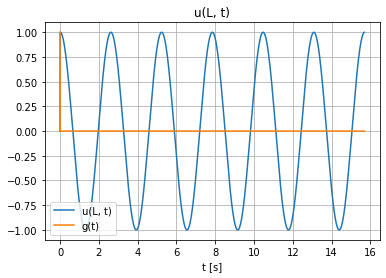

In [13]:
plt.plot(t, y[1, :], label='u(L, t)')
plt.plot(t, g, label='g(t)')
plt.title('u(L, t)')
plt.xlabel('t [s]')
plt.grid()
plt.legend()